make Azimuthal Equidistant Projection  
using map_templateb_table.html 

In [143]:
from collections import defaultdict
import vmapper
import os
import numpy as np
from shapely.geometry import Point
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from catppuccin_palette import catppuccin as cpc
import mplcatppuccin
from mplcatppuccin.palette import load_color
from mplcatppuccin.colormaps import get_colormap_from_list
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
#from jinja2 import Environment, PackageLoader, select_autoescape
import jinja2

/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/geopandas/geodataframe.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[exploded_geom.name] = exploded_geom.values
/tmp/ipykernel_164609/2728975135.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf3['area'] = gdf3.area


<Axes: >

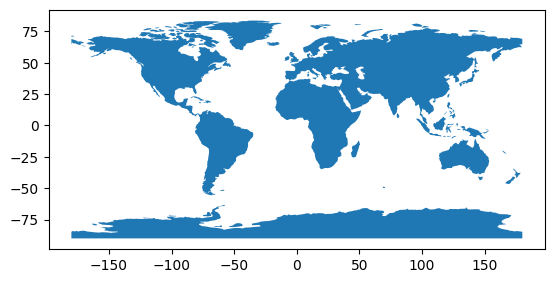

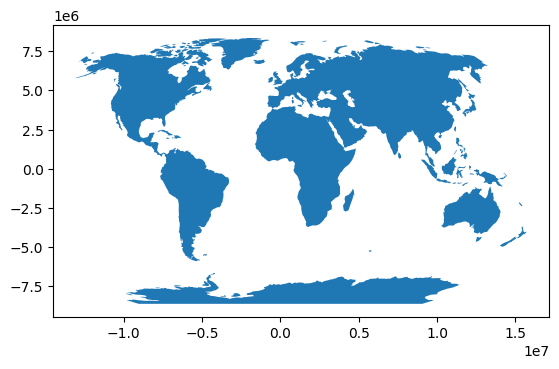

In [172]:
fp = '../data/natural_earth/ne_110m_admin_0_countries2.shp'
#fp = 'data/natural_earth/ne_110m_land.shp'
gdf = gpd.read_file(fp)
gdf2 = gdf.dissolve().explode(index_parts=True)
gdf3 = gdf2[['featurecla', 'geometry']].copy()
gdf3['area'] = gdf3.area
gdf4 = gdf3[gdf3['area']>1]
gdf4 = gdf4.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
gdf4.plot()
#gdf.plot()
this_crs = '+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
gdf4.to_crs(this_crs).plot()

<Axes: >

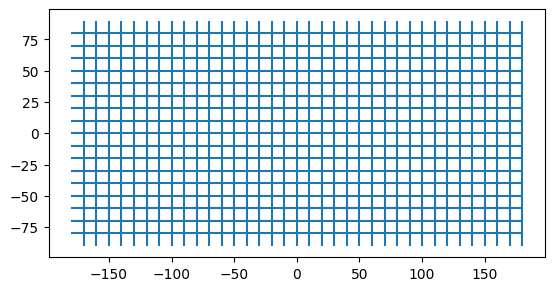

In [173]:
fp = '../data/natural_earth/ne_110m_graticules_10.shp'
grid = gpd.read_file(fp)
grid['display0'] = [d.replace(' ', '') for d in grid['display']]

grid.plot()

In [174]:
grid.head()

,degrees,direction,display,scalerank,dd,geometry,display0
0,80,N,80 N,4,80,"LINESTRING (180.00000 79.99848, 179.99664 79.9...",80N
1,70,N,70 N,4,70,"LINESTRING (180.00000 69.99847, 179.99664 69.9...",70N
2,60,N,60 N,4,60,"LINESTRING (180.00000 59.99866, 179.99664 59.9...",60N
3,50,N,50 N,4,50,"LINESTRING (179.99990 49.99876, 179.99664 49.9...",50N
4,40,N,40 N,4,40,"LINESTRING (179.99990 39.99875, 179.99664 39.9...",40N


In [175]:
gdf4.head()

,id,featurecla,geometry,area
0,0,Admin-0 country,"POLYGON ((-163.71290 -78.59567, -163.71290 -78...",3.716703
1,1,Admin-0 country,"POLYGON ((-122.40624 -73.32462, -121.21151 -73...",1.541898
2,2,Admin-0 country,"POLYGON ((-100.78346 -72.50162, -101.80187 -72...",3.004556
3,3,Admin-0 country,"POLYGON ((-78.18210 8.31918, -78.43547 8.38771...",4158.334445
4,4,Admin-0 country,"POLYGON ((-128.35841 50.77065, -127.30858 50.5...",4.056773


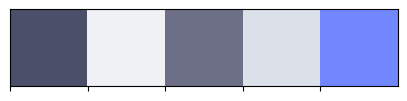

In [176]:
DARK = load_color('latte', 'text')
WHITE = load_color('latte', 'base')
LIGHTGRAY = load_color('latte', 'crust')
GRAY = load_color('latte', 'subtext0')
LINE = load_color('latte', 'lavender')
sns.palplot([DARK, WHITE, GRAY, LIGHTGRAY, LINE])

In [177]:
def generate_svg2(m, the_gdf, the_grid, title, vis):
    #m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})
    m.add_geodataframe(the_grid, layername='{}-grid'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='display0', idby='display2'),
        strokecolor=LINE, opacity=0.7,
        strokewidth=30000, showlabel=False, visibility=vis)
    m.add_geodataframe(the_gdf, layername='{}-land'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='id', idby='id2'), 
        color=DARK, opacity=0.6, strokecolor=DARK, strokewidth=30, showlabel=False, 
        visibility=vis)
    #m.add_title(title+' Projection')

In [179]:

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    print(x)

0
30
60
90
120
150
180
-150
-120
-90
-60
-30


In [180]:
projections = {}

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    x2 = 'E{}'.format(x) if x>0 else 'W{}'.format(abs(x)) if x<0 else 'EW{}'.format(x)
    n = x2
    #print(n)
    this_crs = '+proj=robin +lon_0={} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' .format(x)
    projections[n] = this_crs
    #print(this_crs)
    #gdf4.to_crs(this_crs).plot(fc='none', ec='k')
    #grid.to_crs(this_crs).plot(fc='none', ec='k')
len(projections)


12

In [181]:
projections

{'EW0': '+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E30': '+proj=robin +lon_0=30 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E60': '+proj=robin +lon_0=60 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E90': '+proj=robin +lon_0=90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E120': '+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E150': '+proj=robin +lon_0=150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'E180': '+proj=robin +lon_0=180 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'W150': '+proj=robin +lon_0=-150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'W120': '+proj=robin +lon_0=-120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'W90': '+proj=robin +lon_0=-90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'W60': '+proj=robin +lon_0=-60 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
 'W30': '+proj=robi

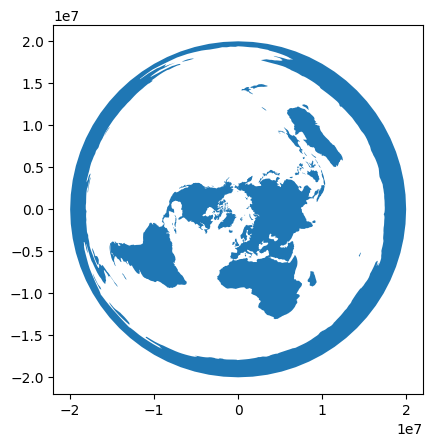

In [163]:

for k, crs in projections.items():
    the_grid = grid.to_crs(crs).copy()
    the_gdf = gdf4.to_crs(crs).copy() 
    the_gdf = check_geom(the_gdf, gdf4)
    the_gdf.plot()
    break

In [182]:
m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})


check = 0
proj_list = []
for k, crs in projections.items():
    vis = 'hidden' if check>0 else 'visible'
    the_grid = grid.to_crs(crs).copy()
    the_gdf = gdf4.to_crs(crs).copy() 
    #the_gdf = check_geom(the_gdf, gdf4)
    k2 = k.replace(' ', '_')
    the_gdf['id2'] = ['{}-{}'.format(k2, i) for i in the_gdf['id']]
    the_grid['display2'] = ['{}-{}'.format(k2, i) for i in the_grid['display0']]
    #print(the_gdf)
    generate_svg2(m, the_gdf, the_grid, k, vis)
    proj_list.append(k)
    print(k)
    check+=1
    #if check==4:
    #    break


EW0
E30
E60
E90
E120
E150
E180
W150
W120
W90
W60
W30


In [183]:
svgText = m.make_scene()
#print(outputText)


In [184]:
temp_vars = {'first_title': proj_list[0], 
             'first_proj4': projections[proj_list[0]],
             'content': svgText,
             'projections_collection': proj_list[1:],
             'projs': projections,
}
temp_vars['first_title']

'EW0'

In [185]:
templateLoader = jinja2.FileSystemLoader( searchpath="." )
templateEnv = jinja2.Environment( loader=templateLoader )
TEMPLATE_FILE = "map_templateb.html"

template = templateEnv.get_template( TEMPLATE_FILE )
outputText = template.render( temp_vars )

outputfn = 'test5.html'

with open(outputfn, 'wb') as f:
    f.write(outputText.encode("utf-8"))